<a href="https://colab.research.google.com/github/viktoriya-bel/Tensorflow-labs/blob/main/LabTimeSeries_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

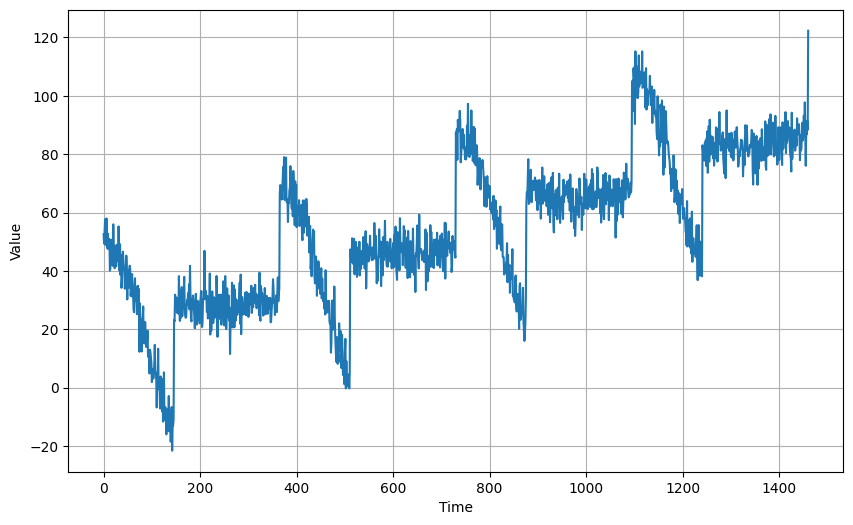

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")

series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
year = 365

time = np.arange(4 * year + 1, dtype="float32")
# Создание серии
series = baseline + trend(time, slope) + seasonality(time, period=year, amplitude=amplitude)
# Добавление шума
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [116]:
# принимает временной ряд данных и параметры: размер окна, размер пакетов, используемых при обучении, и размер буфера перемешивания, который определяет, как данные будут перемешиваться.
def window_dataset(series, window_size, batсh_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batсh_size).prefetch(1)
  return dataset

In [117]:
# подготовка тренировочного и валидационного наборов
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [118]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [119]:
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1, activation="relu")
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
history = model.fit(dataset, epochs=100, verbose=0)




1/1 [==============================] - 0s 22ms/step


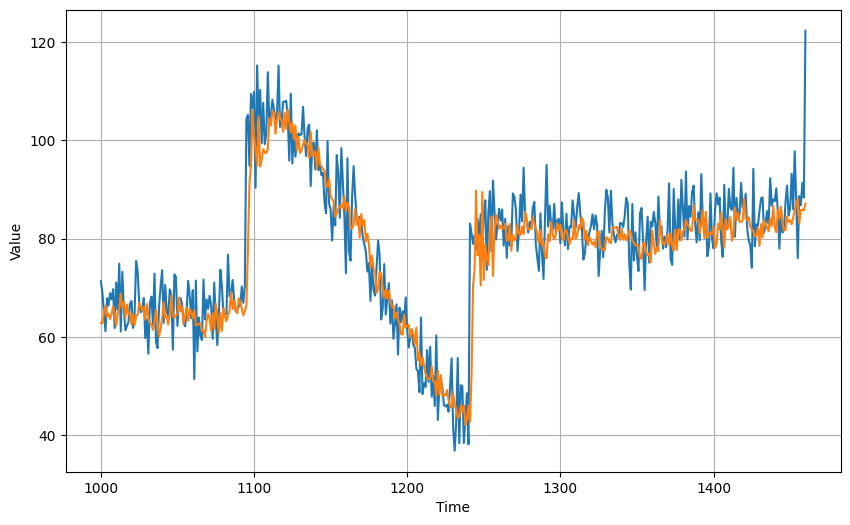

In [120]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [121]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.0001, 0.0, 300.0)

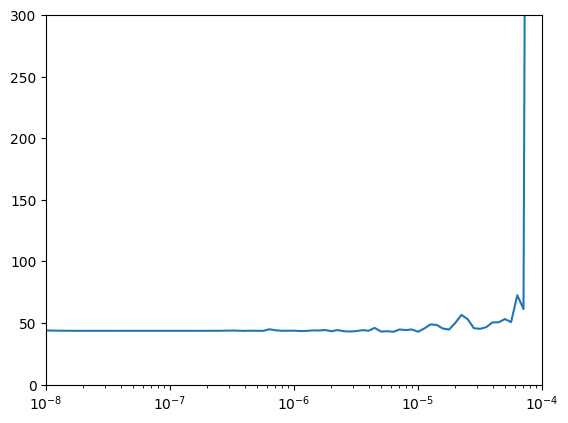

In [122]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 300])

In [138]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1, activation="relu")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

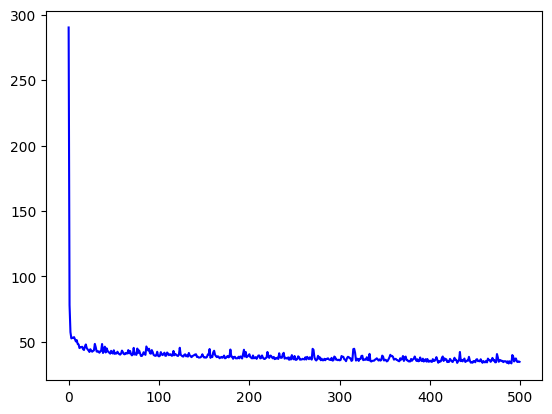

In [142]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[48.40004348754883, 48.106529235839844, 45.25251770019531, 45.884605407714844, 45.967159271240234, 46.26492691040039, 44.367095947265625, 43.802330017089844, 46.441036224365234, 48.012535095214844, 45.311676025390625, 44.2758674621582, 43.40067672729492, 42.29232406616211, 44.366119384765625, 43.36903762817383, 42.46415710449219, 43.04753875732422, 43.4965705871582, 48.45146942138672, 45.870574951171875, 42.606075286865234, 42.52037048339844, 42.772464752197266, 41.70521926879883, 42.68547058105469, 43.31856918334961, 48.34878158569336, 41.486480712890625, 43.14894485473633, 46.329368591308594, 41.88542938232422, 45.08885955810547, 43.311344146728516, 42.24577713012695, 41.697242736816406, 40.9970817565918, 43.14162826538086, 41.71739959716797, 41.05879592895508, 43.5732307434082, 40.83807373046875, 41.528175354003906, 41.038761138916016, 42.45719528198242, 41.326210021972656, 40.613006591796875, 40.23849868774414, 41.011268615722656, 43.30972671508789, 42.171932220458984, 40.733627319

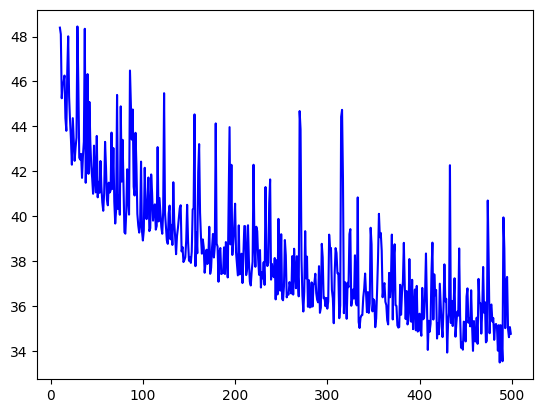

In [143]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 17ms/step


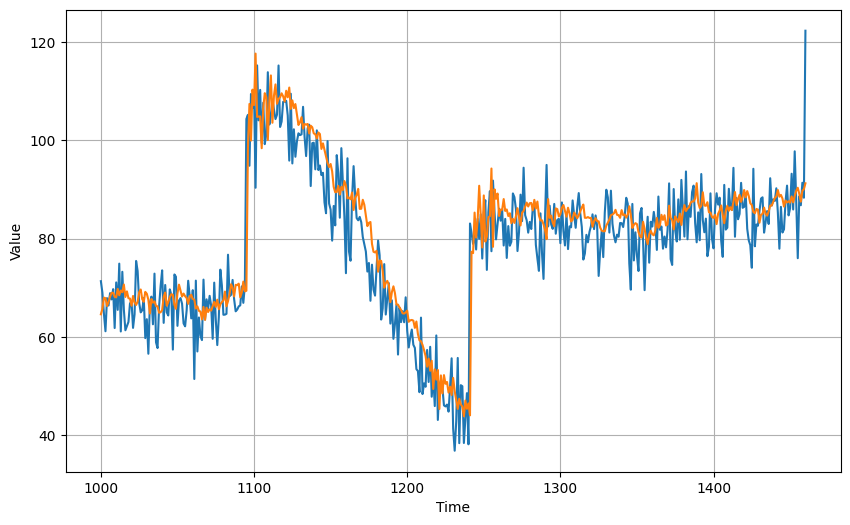

In [144]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)